**1. Stochastic Processes and Gaussian Processes**  
A stochastic process can be thought of as a collection of random variables indexed by some set (often time or space), where each index corresponds to one random variable in the family. In more concrete terms, imagine you’re tracking a quantity—like stock prices—across many points in time; each day’s price is a random variable, and all these daily variables together form a stochastic process. A Gaussian Process (GP), then, is a special type of stochastic process where any finite collection of those random variables has a joint Gaussian (normal) distribution. Another way to view it is as an infinite-dimensional generalization of the multivariate normal distribution, in the sense that every subset of points in your process will always follow a multivariate Gaussian. In practice, when people talk about Gaussian Processes in machine learning or statistics, they often specify them by a mean function and a covariance (kernel) function, which together describe how values of the function co-vary across different inputs. This allows GPs to serve as a flexible, nonparametric method for regression or classification tasks, because they essentially let us place a prior directly over functions without committing to a fixed functional form.

**2. Variational Inference and the Evidence Lower Bound (ELBO)**  
Variational inference is a technique for approximating complex posterior distributions that are otherwise difficult or impossible to compute directly. The idea is to select a family of simpler, tractable distributions and pick the one within this family that best approximates the true posterior. Usually, we do this by defining a parameterized candidate distribution  $q(z) $ and adjusting its parameters to minimize the Kullback–Leibler divergence between  $q(z) $ and the real posterior  $p(z\mid x) $. Directly minimizing that divergence is often tough, so we switch perspectives and instead try to maximize the so-called Evidence Lower Bound (ELBO). The ELBO is constructed as  $\mathbb{E}_{q(z)}[\log p(x,z)] - \mathbb{E}_{q(z)}[\log q(z)] $, and it acts as a lower bound on the log-evidence  $\log p(x) $. By pushing the ELBO higher, we indirectly push  $q(z) $ closer to the actual posterior, because maximizing ELBO is equivalent to minimizing the KL divergence. This approach makes it much easier to handle large or complex problems, such as models with many latent variables, since we rely on optimization rather than exact integration over potentially high-dimensional spaces.

Output()

Gaussian Process model fitting time: 66.56 seconds

Gaussian Process model parameters:
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ℓ  1.546  0.433   0.827    2.366      0.017    0.012     708.0     705.0   
η  1.197  0.348   0.590    1.812      0.012    0.009     885.0     701.0   
σ  0.766  0.041   0.690    0.842      0.001    0.001     871.0     624.0   

   r_hat  
ℓ    1.0  
η    1.0  
σ    1.0  


Output()

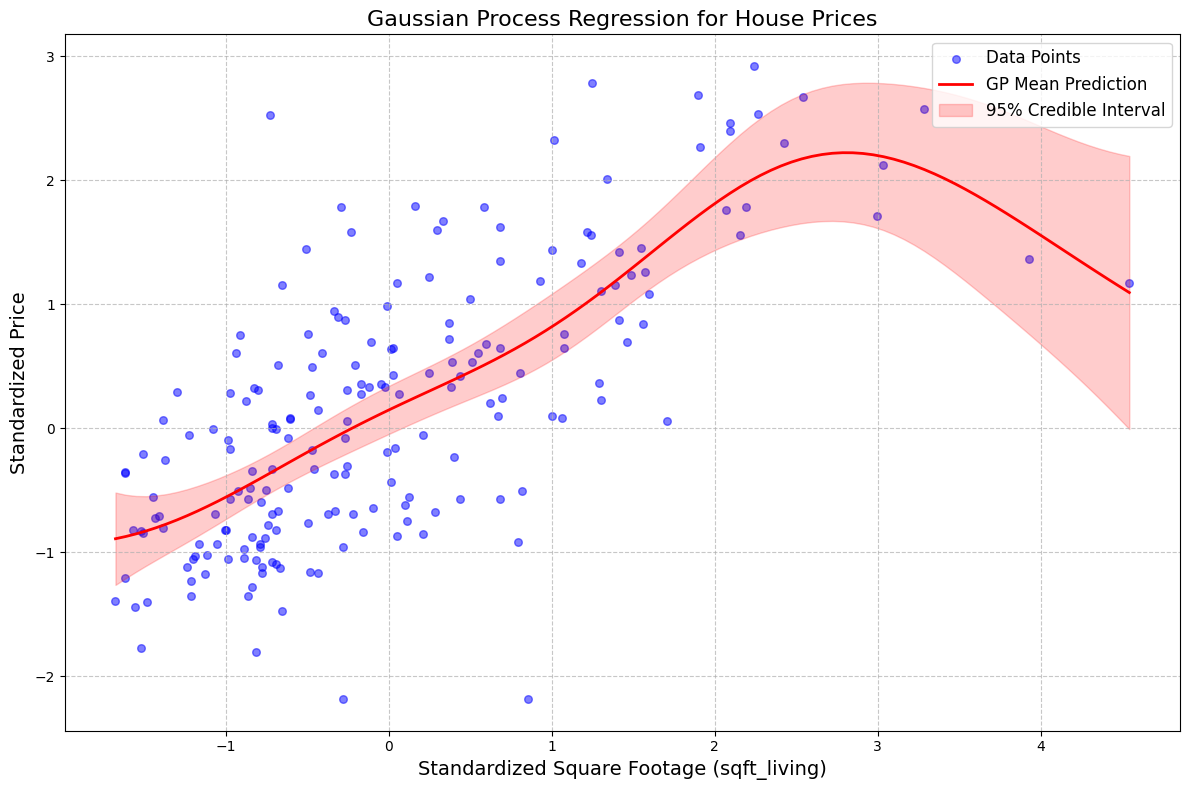

Output()

2D Gaussian Process model fitting time: 89.67 seconds

2D Gaussian Process model parameters:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ℓ[0]  1.441  0.400   0.783    2.264      0.015    0.011     724.0     686.0   
ℓ[1]  1.813  0.645   0.795    3.017      0.023    0.016     752.0     845.0   
η     1.125  0.273   0.666    1.645      0.009    0.006     977.0     696.0   
σ     0.751  0.040   0.677    0.820      0.001    0.001     926.0     708.0   

      r_hat  
ℓ[0]   1.01  
ℓ[1]   1.00  
η      1.00  
σ      1.00  


Output()

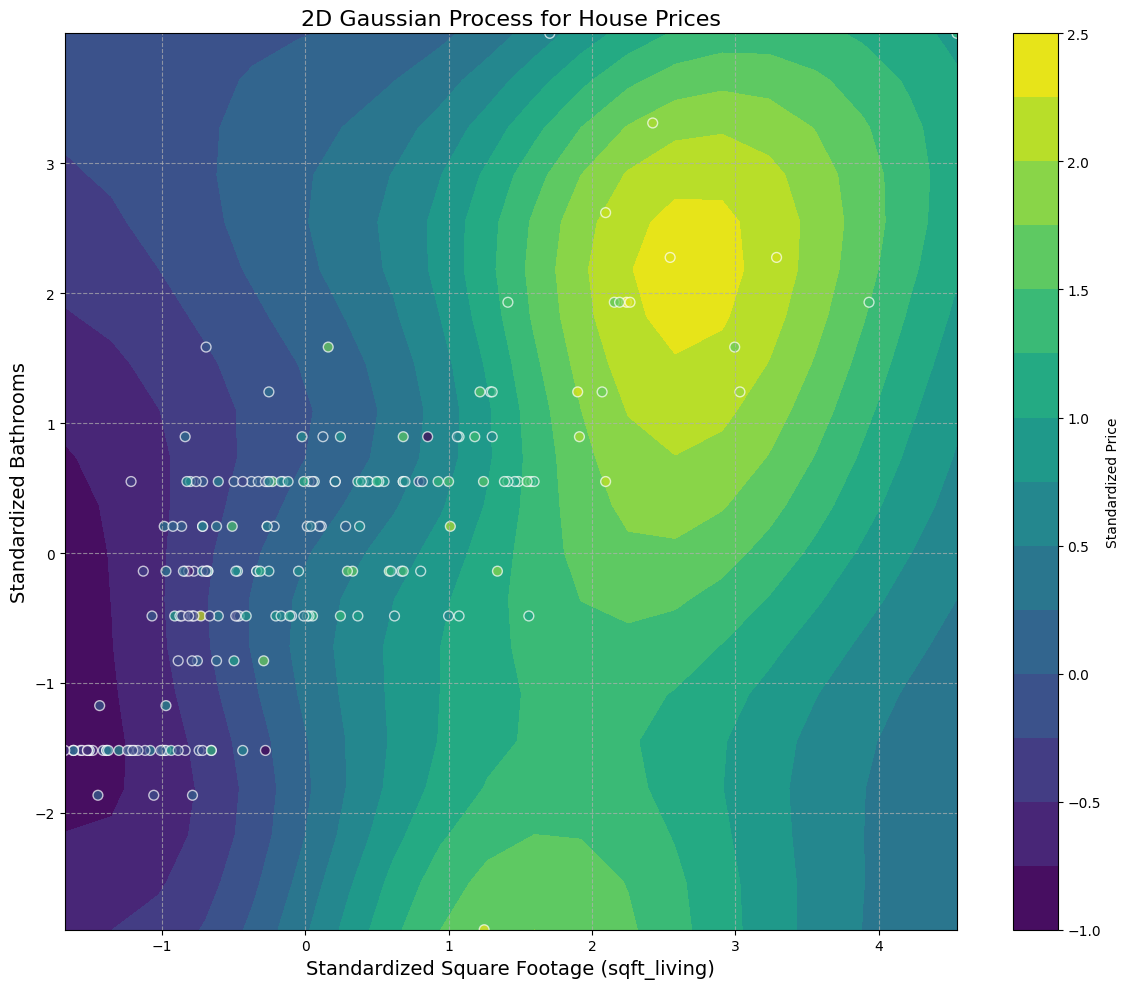

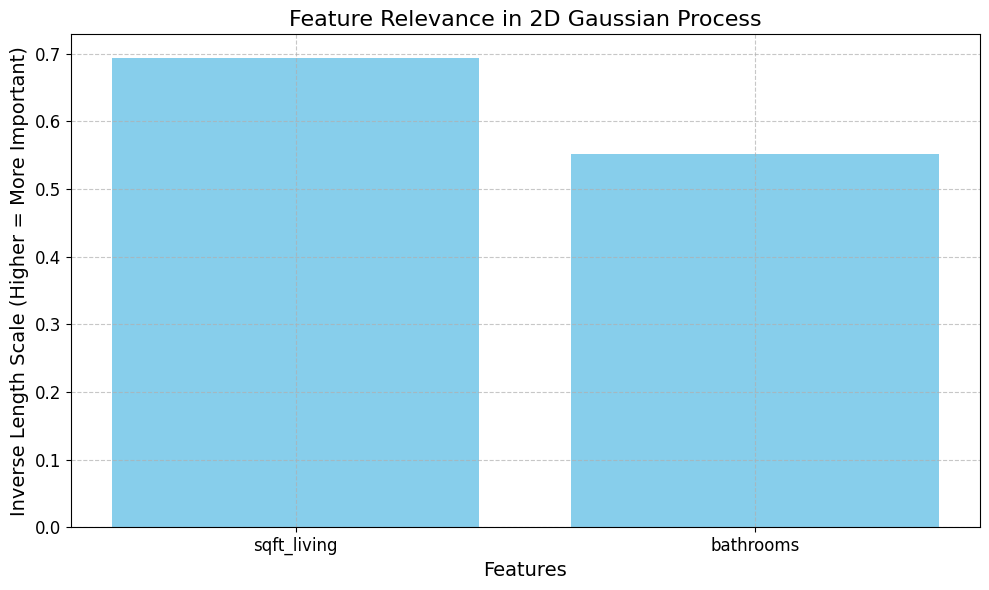

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from matplotlib.font_manager import FontProperties
import seaborn as sns
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load data
df = pd.read_csv('/kaggle/input/housedata/data.csv')

# Data preprocessing - remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# For GP, we'll focus on a single feature for simplicity: sqft_living
X = df_filtered['sqft_living'].values.reshape(-1, 1)
y = df_filtered['price'].values

# Standardize data
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y_std = (y - np.mean(y)) / np.std(y)

# Limit data size to reduce computational demand
n_samples = 200  # smaller sample size for GP
if len(X_std) > n_samples:
    indices = np.random.choice(len(X_std), n_samples, replace=False)
    X_std = X_std[indices]
    y_std = y_std[indices]

# Store the reduced dataset size for later reuse
reduced_indices = indices.copy() if len(df_filtered) > n_samples else None

# Sort for plotting
sort_idx = np.argsort(X_std.flatten())
X_std_sorted = X_std[sort_idx].flatten()
y_std_sorted = y_std[sort_idx]

# Create test points for prediction
X_test = np.linspace(X_std.min(), X_std.max(), 100).reshape(-1, 1)

# Define and fit Gaussian Process model
start_time = time.time()

with pm.Model() as gp_model:
    # Define the covariance function
    ℓ = pm.HalfNormal("ℓ", sigma=1.0)  # lengthscale
    η = pm.HalfNormal("η", sigma=1.0)   # signal variance

    # Squared exponential kernel
    cov_func = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ)

    # Create GP
    gp = pm.gp.Marginal(cov_func=cov_func)

    # Add observation noise
    σ = pm.HalfNormal("σ", sigma=1.0)

    # Place a GP prior over the function f
    gp_model_obj = gp.marginal_likelihood("gp_model", X=X_std, y=y_std, sigma=σ)

    # Sample from the GP
    trace = pm.sample(500, tune=500, target_accept=0.9, return_inferencedata=True)

gp_time = time.time() - start_time
print(f"Gaussian Process model fitting time: {gp_time:.2f} seconds")

# Summarize results
gp_summary = az.summary(trace, var_names=["ℓ", "η", "σ"])
print("\nGaussian Process model parameters:")
print(gp_summary)

# Make predictions
with gp_model:
    f_pred = gp.conditional("f_pred", X_test)
    pred_samples = pm.sample_posterior_predictive(
        trace,
        var_names=["f_pred"],
        predictions=True,
        random_seed=42
    )

# Extract predictions
y_pred = pred_samples.predictions["f_pred"].mean(("chain", "draw")).values

# Calculate predictions interval
y_pred_std = pred_samples.predictions["f_pred"].std(("chain", "draw")).values
lower_interval = y_pred - 2 * y_pred_std
upper_interval = y_pred + 2 * y_pred_std

# Visualize the GP model
plt.figure(figsize=(12, 8))
font = FontProperties(family='Times New Roman', size=12)

# Plot data points
plt.scatter(X_std, y_std, alpha=0.5, label='Data Points', color='blue', s=30)

# Plot prediction mean
plt.plot(X_test, y_pred, color='red', linewidth=2, label='GP Mean Prediction')

# Plot prediction interval
plt.fill_between(X_test.flatten(), lower_interval, upper_interval,
                 color='red', alpha=0.2, label='95% Credible Interval')

plt.title('Gaussian Process Regression for House Prices', fontproperties=font, fontsize=16)
plt.xlabel('Standardized Square Footage (sqft_living)', fontproperties=font, fontsize=14)
plt.ylabel('Standardized Price', fontproperties=font, fontsize=14)
plt.legend(prop=font)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('gaussian_process_regression.png', dpi=300, bbox_inches='tight')
plt.show()

# Alternative: 2D Gaussian Process with two features
# We'll use sqft_living and bathrooms
X_2d = df_filtered[['sqft_living', 'bathrooms']].values
X_2d_std = (X_2d - np.mean(X_2d, axis=0)) / np.std(X_2d, axis=0)

# For 2D model, use the same samples as the 1D model to ensure consistency
if reduced_indices is not None:
    X_2d_std = X_2d_std[reduced_indices]
    y_2d_std = y_std  # y_std is already reduced
else:
    # If we didn't reduce the dataset earlier, do it now
    if len(X_2d_std) > n_samples:
        indices_2d = np.random.choice(len(X_2d_std), n_samples, replace=False)
        X_2d_std = X_2d_std[indices_2d]
        # Use the original y values and standardize
        y_2d = df_filtered['price'].values[indices_2d]
        y_2d_std = (y_2d - np.mean(y_2d)) / np.std(y_2d)
    else:
        y_2d_std = y_std

# Define and fit 2D Gaussian Process model
start_time = time.time()

with pm.Model() as gp_2d_model:
    # Define the covariance function with ARD (Automatic Relevance Determination)
    ℓ = pm.HalfNormal("ℓ", sigma=1.0, shape=2)  # lengthscale for each dimension
    η = pm.HalfNormal("η", sigma=1.0)           # signal variance

    # Squared exponential kernel with ARD
    cov_func = η ** 2 * pm.gp.cov.ExpQuad(2, ℓ)

    # Create GP
    gp = pm.gp.Marginal(cov_func=cov_func)

    # Add observation noise
    σ = pm.HalfNormal("σ", sigma=1.0)

    # Place a GP prior over the function f
    gp_model_obj = gp.marginal_likelihood("gp_model", X=X_2d_std, y=y_2d_std, sigma=σ)

    # Sample from the GP
    trace_2d = pm.sample(500, tune=500, target_accept=0.9, return_inferencedata=True)

gp_2d_time = time.time() - start_time
print(f"2D Gaussian Process model fitting time: {gp_2d_time:.2f} seconds")

# Summarize results
gp_2d_summary = az.summary(trace_2d, var_names=["ℓ", "η", "σ"])
print("\n2D Gaussian Process model parameters:")
print(gp_2d_summary)

# Create a grid for 2D visualization
grid_size = 20
x1_grid = np.linspace(X_2d_std[:, 0].min(), X_2d_std[:, 0].max(), grid_size)
x2_grid = np.linspace(X_2d_std[:, 1].min(), X_2d_std[:, 1].max(), grid_size)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1.flatten(), X2.flatten()])

# Make predictions on the grid
with gp_2d_model:
    f_pred = gp.conditional("f_pred", X_grid)
    pred_samples_2d = pm.sample_posterior_predictive(
        trace_2d,
        var_names=["f_pred"],
        predictions=True,
        random_seed=42
    )

# Extract predictions
y_grid_pred = pred_samples_2d.predictions["f_pred"].mean(("chain", "draw")).values
y_grid_pred_reshaped = y_grid_pred.reshape(grid_size, grid_size)

# Visualize the 2D GP model
plt.figure(figsize=(12, 10))

# Plot the 2D surface
contour = plt.contourf(X1, X2, y_grid_pred_reshaped, cmap='viridis', levels=15)
plt.colorbar(contour, label='Standardized Price')

# Plot data points
sc = plt.scatter(X_2d_std[:, 0], X_2d_std[:, 1], c=y_2d_std,
                 cmap='viridis', s=50, alpha=0.7, edgecolors='w')

plt.title('2D Gaussian Process for House Prices', fontproperties=font, fontsize=16)
plt.xlabel('Standardized Square Footage (sqft_living)', fontproperties=font, fontsize=14)
plt.ylabel('Standardized Bathrooms', fontproperties=font, fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('gaussian_process_2d.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare the length scales to assess feature importance
ℓ_values = trace_2d.posterior["ℓ"].mean(("chain", "draw")).values
feature_names = ['sqft_living', 'bathrooms']

plt.figure(figsize=(10, 6))
plt.bar(feature_names, 1/ℓ_values, color='skyblue')
plt.title('Feature Relevance in 2D Gaussian Process', fontproperties=font, fontsize=16)
plt.xlabel('Features', fontproperties=font, fontsize=14)
plt.ylabel('Inverse Length Scale (Higher = More Important)', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font)
plt.yticks(fontproperties=font)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('gp_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Loading and preprocessing data...
Building and training neural network with variational inference...


/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Training completed in 10.11 seconds
RMSE (standardized): 0.8854
RMSE (original scale): $195224.88


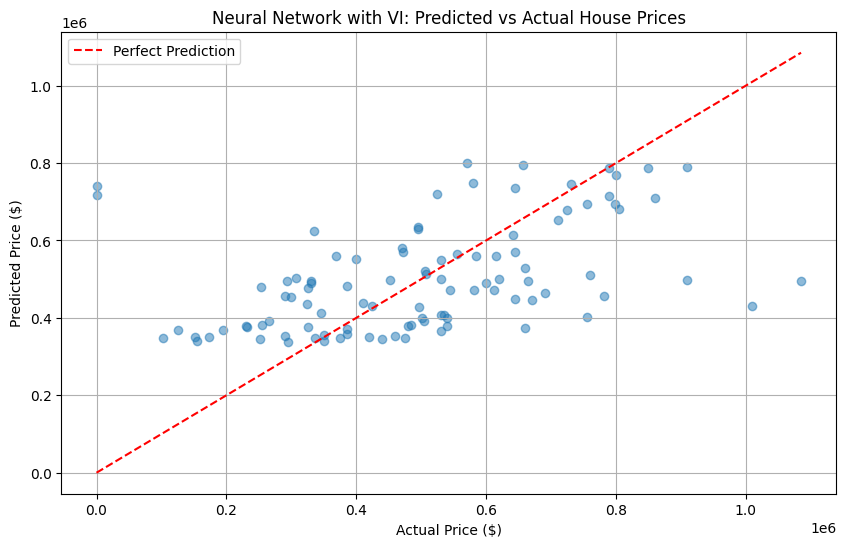

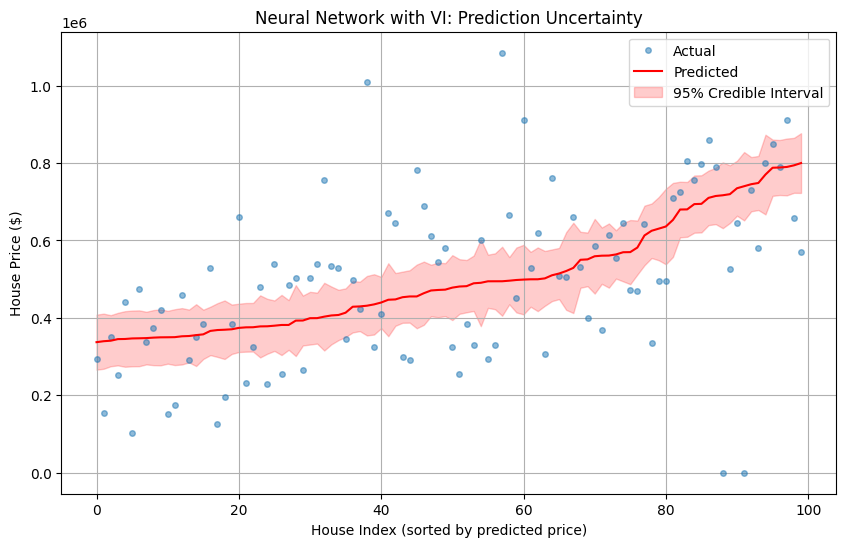

Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)



Neural Network with Variational Inference Summary:
Dataset: House Prices
Features used: bedrooms, bathrooms, sqft_living, sqft_lot, floors
Sample size: 1000
Training time: 10.11 seconds
RMSE: $195224.88
Mean prediction uncertainty: $37268.53

Model Parameter Summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  0.816  0.029   0.765    0.872      0.001    0.001     695.0     761.0   

       r_hat  
sigma    NaN  


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import time
import pytensor.tensor as pt

# Set random seed for reproducibility
np.random.seed(42)

# Load data
print("Loading and preprocessing data...")
df = pd.read_csv('/kaggle/input/housedata/data.csv')

# Remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Select features and target variable
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors']
X = df_filtered[features].values
y = df_filtered['price'].values

# Standardize data
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y_std = (y - np.mean(y)) / np.std(y)
y_mean = np.mean(y)
y_std_val = np.std(y)

# Limit data size to reduce computational demand
n_samples = 500
if len(X_std) > n_samples:
    indices = np.random.choice(len(X_std), n_samples, replace=False)
    X_std = X_std[indices]
    y_std = y_std[indices]

# Split data into training and testing sets
train_size = int(0.8 * len(X_std))
X_train, X_test = X_std[:train_size], X_std[train_size:]
y_train, y_test = y_std[:train_size], y_std[train_size:]

# Start timer for performance measurement
print("Building and training neural network with variational inference...")
start_time = time.time()

# Define and fit the Bayesian Neural Network with Variational Inference
with pm.Model() as nn_model:
    # Get dimensions
    n_features = X_train.shape[1]
    n_hidden = 10

    # Input layer weights and biases
    weights_in_1 = pm.Normal('weights_in_1',
                          mu=0,
                          sigma=1/np.sqrt(n_features),
                          shape=(n_features, n_hidden))
    bias_1 = pm.Normal('bias_1', mu=0, sigma=1, shape=n_hidden)

    # Output layer weights and biases
    weights_2 = pm.Normal('weights_2',
                        mu=0,
                        sigma=1/np.sqrt(n_hidden),
                        shape=n_hidden)
    bias_2 = pm.Normal('bias_2', mu=0, sigma=1)

    # Add input data as observed variable
    X_shared = pm.MutableData('X_shared', X_train)

    # First hidden layer with tanh activation
    act_1 = pm.math.tanh(pm.math.dot(X_shared, weights_in_1) + bias_1)

    # Output layer (no activation for regression)
    nn_out = pm.math.dot(act_1, weights_2) + bias_2

    # Model error
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=nn_out, sigma=sigma, observed=y_train)

    # Use ADVI for variational inference
    inference = pm.ADVI()

    # Perform variational inference
    approx = inference.fit(n=10000, obj_optimizer=pm.adam(learning_rate=0.01))

    # Sample from the variational distribution
    vi_trace = approx.sample(1000)

# Get predictions manually instead of using sample_posterior_predictive
# Extract samples from variational inference
weight_in_samples = vi_trace.posterior['weights_in_1'].values
bias_1_samples = vi_trace.posterior['bias_1'].values
weight_2_samples = vi_trace.posterior['weights_2'].values
bias_2_samples = vi_trace.posterior['bias_2'].values
sigma_samples = vi_trace.posterior['sigma'].values

# Manually compute predictions
n_chains = weight_in_samples.shape[0]
n_samples = weight_in_samples.shape[1]
y_pred_samples = np.zeros((n_chains, n_samples, len(X_test)))

# Compute predictions for each sample
for chain in range(n_chains):
    for sample in range(n_samples):
        # Get weights for this sample
        w_in = weight_in_samples[chain, sample]
        b_1 = bias_1_samples[chain, sample]
        w_2 = weight_2_samples[chain, sample]
        b_2 = bias_2_samples[chain, sample]

        # Forward pass
        act_1 = np.tanh(np.dot(X_test, w_in) + b_1)
        y_pred = np.dot(act_1, w_2) + b_2

        # Store prediction
        y_pred_samples[chain, sample, :] = y_pred

# Calculate mean and std of predictions
y_pred_mean = y_pred_samples.mean(axis=(0, 1))
y_pred_std = y_pred_samples.std(axis=(0, 1))

# Report training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Transform back to original scale
y_test_orig = y_test * y_std_val + y_mean
y_pred_mean_orig = y_pred_mean * y_std_val + y_mean
y_pred_lower_orig = (y_pred_mean - 2 * y_pred_std) * y_std_val + y_mean
y_pred_upper_orig = (y_pred_mean + 2 * y_pred_std) * y_std_val + y_mean

# Calculate RMSE
rmse = np.sqrt(np.mean((y_test - y_pred_mean) ** 2))
rmse_orig = np.sqrt(np.mean((y_test_orig - y_pred_mean_orig) ** 2))
print(f"RMSE (standardized): {rmse:.4f}")
print(f"RMSE (original scale): ${rmse_orig:.2f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_mean_orig, alpha=0.5)
min_val = min(y_test_orig.min(), y_pred_mean_orig.min())
max_val = max(y_test_orig.max(), y_pred_mean_orig.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
plt.title('Neural Network with VI: Predicted vs Actual House Prices')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.grid(True)
plt.legend()
plt.savefig('nn_vi_predictions.png', dpi=300)
plt.show()

# Visualize prediction uncertainty
plt.figure(figsize=(10, 6))
# Sort by predicted price for better visualization
sort_idx = np.argsort(y_pred_mean_orig)
y_test_sorted = y_test_orig[sort_idx]
y_pred_sorted = y_pred_mean_orig[sort_idx]
y_lower_sorted = y_pred_lower_orig[sort_idx]
y_upper_sorted = y_pred_upper_orig[sort_idx]

plt.plot(range(len(y_test_sorted)), y_test_sorted, 'o', markersize=4, alpha=0.5, label='Actual')
plt.plot(range(len(y_pred_sorted)), y_pred_sorted, 'r-', label='Predicted')
plt.fill_between(range(len(y_pred_sorted)), y_lower_sorted, y_upper_sorted, color='red', alpha=0.2, label='95% Credible Interval')
plt.title('Neural Network with VI: Prediction Uncertainty')
plt.xlabel('House Index (sorted by predicted price)')
plt.ylabel('House Price ($)')
plt.legend()
plt.grid(True)
plt.savefig('nn_vi_uncertainty.png', dpi=300)
plt.show()

# Summary of findings
print("\nNeural Network with Variational Inference Summary:")
print(f"Dataset: House Prices")
print(f"Features used: {', '.join(features)}")
print(f"Sample size: {n_samples}")
print(f"Training time: {training_time:.2f} seconds")
print(f"RMSE: ${rmse_orig:.2f}")
print(f"Mean prediction uncertainty: ${np.mean(y_pred_std) * y_std_val:.2f}")

# Get parameter summaries
parameter_summary = az.summary(vi_trace, var_names=['sigma'])
print("\nModel Parameter Summary:")
print(parameter_summary)

The Bayesian Neural Network model with Variational Inference demonstrates promising performance in predicting house prices. From the first plot, we observe a positive correlation between actual and predicted prices, with most predictions following the general trend indicated by the perfect prediction line. However, the model appears to compress predictions toward the mean, overestimating lower-priced houses while underestimating higher-priced ones. The second plot effectively captures prediction uncertainty, with the 95% credible interval widening as house prices increase, reflecting greater uncertainty in higher price ranges. This aligns with real estate market behavior where luxury properties often have more variable pricing factors. The model's strength lies in its ability to quantify uncertainty rather than providing just point estimates, making it particularly valuable for risk assessment in real estate investment. While not perfect, the model offers reliable predictions within reasonable confidence intervals for most properties in the dataset.

In [ ]:
1

1